# Connect 4 with CNNs
This Notebook implements a CNN that will be playing connect 4. It will be trained on a dataset of moves. Each sample in this set will contain a __board__ as a 6x7-pixel image, a __current player__ as scalar and a __target column__ as one hot vector. The model will then be trained to predict the target column depending on a board and a current player. Following sections are contained:

- **Building the Dataset**
- **Building the Model**
- **Training the Model**
- **Testing the Model**

## **Building the Datasets**
The samples are read from the file system and put into an Connect4Dataset. Each sample contains __board__, __current player__ and __target column__

Found 17044 samples


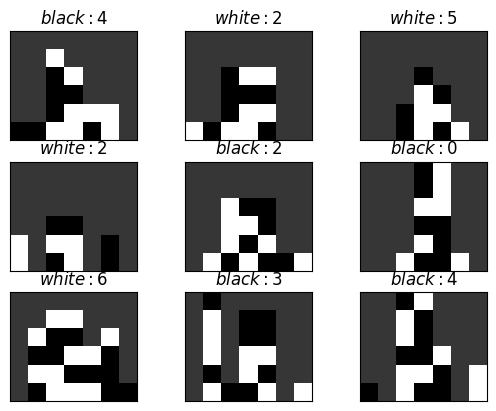

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

BATCH_SIZE = 10
NUM_EPOCHS = 100  # Number of training epochs

class C4Dataset(Dataset):
    """
    The C4Dataset is responsible for retrieving labeled data from the fs.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.player_folders = {'black': 0, 'white': 1}
        self.num_columns = 7

        self.data = self.load_data()

    def load_data(self):
        """
        Retrieves the data from the fs. Images are stored by their path to save memory.
        :return: the data 
        """
        data = []

        for player, player_idx in self.player_folders.items():
            player_dir = os.path.join(self.root_dir, player)

            for target_column in range(0, self.num_columns):
                column_dir = os.path.join(player_dir, str(target_column))
                image_filenames = os.listdir(column_dir)

                for image_filename in image_filenames:
                    image_path = os.path.join(column_dir, image_filename)
                    data.append((image_path, player_idx, torch.eye(self.num_columns)[target_column]))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Only here are images finally opened
        :param idx: idx of the sample
        :return: the image, player and target_column
        """
        image_path, player, target_column = self.data[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, player, target_column

def build_dataset(root_dir, training_testing_ratio):
    # Define your transformations
    transform = transforms.Compose([
        transforms.Resize((6, 7)),    # Resize the images to a consistent size (e.g., 64x64)
        transforms.Grayscale(),       # Convert images to grayscale
        transforms.ToTensor(),        # Convert images to PyTorch tensors
    ])
    
    # Define your dataset
    dataset = C4Dataset(root_dir, transform=transform)
    print(f"Found {len(dataset)} samples")
    
    # split in test and training data
    training_testing_size = (np.asarray(training_testing_ratio)[0:-1] * len(dataset)).astype(int)
    training_testing_size = np.concatenate([training_testing_size, [int(len(dataset) - np.sum(training_testing_size))]])
    sets = torch.utils.data.random_split(dataset, training_testing_size)
    loaders = list(map(lambda s: DataLoader(s, batch_size=BATCH_SIZE, shuffle=True), sets))
    return loaders
    
    # visualize some samples
def show_loader_samples(loader):
    for (board_batch, current_player_batch, column_batch) in loader:
        for i in range(0, min(10, len(board_batch))):
            plt.subplot(331 + i)
            plt.xticks([])
            plt.yticks([])
            plt.title(f"${['black', 'white'][current_player_batch[i]]}:${np.argmax(column_batch[i])}")
            arr = np.asarray(board_batch[i])
            arr = arr.reshape(6, 7)
            plt.imshow(arr, cmap='gray', vmin=0, vmax=1)
            if i == 8:
                return
        plt.show()
    
training, testing = build_dataset(root_dir = "c4set", training_testing_ratio = [0.8, 0.2])
show_loader_samples(training)

## **Building the Model**
As model, we use a CNN. It operates on the image of the board and stacks multiple convolutional layers together to enable Pattern recognition.
It is then followed by a seven layer dense neural network. The first vector of the dense neural network also receives the current player as second input. The produced output vector has length 7. It contains the estimated probabilities of putting the next token in the respective column being the best move.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bot(torch.nn.Module):
    def __init__(self):
        super(Bot, self).__init__()

        self.conv1 = nn.Conv2d(1, 20, (2, 2))
        nn.init.xavier_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(20, 30, (2, 2))
        nn.init.xavier_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(30, 40, (2, 2))
        nn.init.xavier_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(40, 50, (2, 2))
        nn.init.xavier_normal_(self.conv4.weight)
        self.fc1 = nn.Linear(3 * 2 * 50 + 1, 42)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(42 + 1, 42)
        nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(42 + 1, 42)
        nn.init.xavier_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(42 + 1, 42)
        nn.init.xavier_normal_(self.fc4.weight)
        self.fc7 = nn.Linear(42 + 1, 7)
        nn.init.xavier_normal_(self.fc7.weight)

    def forward(self, board, current_player):
        x = F.leaky_relu(self.conv1(board))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = x.view(-1, 3 * 2 * 50)  # Flatten with batch dimension
        player_info = current_player.unsqueeze(1).expand(-1, 1)  # Broadcast across batch
        x = torch.cat((x, player_info), dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = torch.cat((x, player_info), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = torch.cat((x, player_info), dim=1)
        x = F.leaky_relu(self.fc3(x))
        x = torch.cat((x, player_info), dim=1)
        x = F.leaky_relu(self.fc4(x))
        x = torch.cat((x, player_info), dim=1)
        x = self.fc7(x)
        return x

## **Training the Model**
As loss function we use CrossEntropy and as Optimizer SGD.

In [3]:
from torch.optim.lr_scheduler import ExponentialLR

def train(num_epochs):
    bot = Bot()
    binary_cross_entropy = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(bot.parameters(), lr=0.1)
    scheduler = ExponentialLR(optimizer, gamma=0.9)

    for epoch in range(num_epochs):
        running_loss = 0.0
        bot.train()  # Set the model to training mode

        for batch_idx, (board_batch, player_batch, move_batch) in enumerate(training):
            optimizer.zero_grad()
            outputs = bot(board_batch, player_batch)
            loss = binary_cross_entropy(outputs, move_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        print(f"epoch {epoch} --- loss: {running_loss / len(training)}")

    print("Training completed.")
    return bot


def get_accuracy(bot, dataset):
    bot.eval()
    total = 0
    correct = 0
    for board_sample, current_player, best_move in dataset:
        outputs = bot(board_sample, current_player)
        predicted_indices = torch.argmax(outputs, dim=1)
        labeled_indices = torch.argmax(best_move, dim=1)
        total += best_move.size(0)
        correct += (predicted_indices == labeled_indices).sum().item()
    
    bot.train()
    return 100 * correct / total

model = train(NUM_EPOCHS)

epoch 0 --- loss: 1.8394981725824193
epoch 1 --- loss: 1.7579422808986955
epoch 2 --- loss: 1.7248895085277445
epoch 3 --- loss: 1.6887551276914534
epoch 4 --- loss: 1.6330104147321667
epoch 5 --- loss: 1.6083730057624779
epoch 6 --- loss: 1.594132923223406
epoch 7 --- loss: 1.5755613752124595
epoch 8 --- loss: 1.5575094825623672
epoch 9 --- loss: 1.535697206199344
epoch 10 --- loss: 1.5199176079629104
epoch 11 --- loss: 1.5035462168392197
epoch 12 --- loss: 1.4880870505511936
epoch 13 --- loss: 1.4716677875462865
epoch 14 --- loss: 1.4588446123771304
epoch 15 --- loss: 1.4423724595140501
epoch 16 --- loss: 1.4278990036406476
epoch 17 --- loss: 1.4111805532859567
epoch 18 --- loss: 1.3921161590258746
epoch 19 --- loss: 1.3774653854957424
epoch 20 --- loss: 1.3595909131936663
epoch 21 --- loss: 1.3428045617432889
epoch 22 --- loss: 1.3252403093747729
epoch 23 --- loss: 1.3074279888109728
epoch 24 --- loss: 1.293367106281767
epoch 25 --- loss: 1.273969777780544
epoch 26 --- loss: 1.26002

## **Testing the Model**
We give the model the test subset and calculate the accuracy.


In [4]:
test_acc = get_accuracy(model, testing)
print(f"Accuracy on the test set: {test_acc:.2f}%")

training_acc = get_accuracy(model, training)
print(f"Accuracy on the training set: {training_acc:.2f}%")

# test the models ability on selecting game winning moves (this should ideally be close to 100%)
test_winning_moves = build_dataset("winningMoves", [1])[0]
winning_moves_acc = get_accuracy(model, test_winning_moves)
print(f"Accuracy on the winning moves: {winning_moves_acc:.2f}%")

torch.jit.script(model).save("ricardo.pt")

Accuracy on the test set: 44.85%
Accuracy on the training set: 60.29%
Found 136 samples
Accuracy on the winning moves: 62.50%
